Path to github:
https://github.com/BU-IE-582/fall19-erdembanak

In [ ]:
library(data.table)
library(stringr)
library(glmnet)

consumption <- fread("C:/Users/erdem.banak/Documents/IE582/IE582Fall2019_data_files/HW3/Consumption.csv")


In [18]:
colnames(consumption) <- c("Date", "Hour", "Consumption")

consumption[, Date := as.Date(Date, format = "%d.%m.%Y")]
consumption[, Hour := as.integer(substr(Hour, 1, 2))]
consumption[, `:=`(Consumption1 = str_split_fixed(Consumption, ",", 2)[1],
                   Consumption2 = str_split_fixed(Consumption, ",", 2)[2]), .(Date, Hour)]

consumption[, Consumption3 := gsub('\\.', '', Consumption1)]
consumption[, Consumption := as.integer(Consumption3) + as.integer(Consumption2)*(1/10^nchar(Consumption2))]
consumption[, `:=`(Consumption1 = NULL, Consumption2 = NULL, Consumption3 = NULL)]

consumption <- consumption[order(Date, Hour)]

consumption[, Type := ifelse(Date < '2019-11-01', "Train", "Test")]
consumption <- consumption[Date < '2019-11-11',]


In [19]:
# Part A

consumption[, Lag48 := shift(Consumption, type = 'lag', 48)]
consumption[, Lag168 := shift(Consumption, type = 'lag', 168)]

MAPE_48 <- consumption[Type == 'Test', mean(abs(Lag48 - Consumption)/Consumption)]
MAPE_168 <- consumption[Type == 'Test', mean(abs(Lag168 - Consumption)/Consumption)]

print(paste0("Using 2 days before gives the MAPE error of ", round(MAPE_48*100,2), "%"))
print(paste0("Using 7 days before gives the MAPE error of ", round(MAPE_168*100,2), "%"))

MAPE_48_list <- consumption[Type == 'Test', abs(Lag48 - Consumption)/Consumption]
MAPE_168_list <- consumption[Type == 'Test', abs(Lag168 - Consumption)/Consumption]

summary(MAPE_48_list)
summary(MAPE_168_list)

[1] "Using 2 days before gives the MAPE error of 7.82%"
[1] "Using 7 days before gives the MAPE error of 4.04%"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000164 0.0132637 0.0541159 0.0781869 0.0908838 0.4182994 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
6.424e-05 9.263e-03 1.750e-02 4.040e-02 6.313e-02 2.120e-01 

In [20]:
# Part B

train_data <- consumption[Type == "Train",]

lin_mod <- lm(Consumption ~ Lag48 + Lag168, train_data)

intercept <- lin_mod$coefficients[1]
lag48 <- lin_mod$coefficients[2]
lag168 <- lin_mod$coefficients[3]

part_b <- copy(consumption)

part_b[, Prediction := intercept + lag48*Lag48 + lag168*Lag168]

MAPE_b <- part_b[Type == 'Test', mean(abs(Prediction - Consumption)/Consumption)]

print(paste0("Using linear regression of two variables give us MAPE error of ", 
      round(MAPE_b*100,2), "%"))

MAPE_b_list <- part_b[Type == 'Test', (abs(Prediction - Consumption)/Consumption)]

summary(MAPE_b_list)

[1] "Using linear regression of two variables give us MAPE error of 4.53%"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0001094 0.0087319 0.0208819 0.0453490 0.0721326 0.2259201 

In [21]:
models <- data.table()

test_data <- consumption[Type == "Test",]

for (hour in c(0:23)){
  lin_mod <- lm(Consumption ~ Lag48 + Lag168, train_data[Hour == hour,])
  
  intercept <- lin_mod$coefficients[1]
  lag48 <- lin_mod$coefficients[2]
  lag168 <- lin_mod$coefficients[3]

  model <- data.table(Hour = hour, 
                      Intercept = intercept, 
                      Lag48Coef = lag48, 
                      Lag168Coef = lag168)
  
  models <- rbind(model, models)
}

setkey(test_data, Hour)
setkey(models, Hour)

test_data <- models[test_data]

test_data[, Prediction := Intercept + Lag48*Lag48Coef + Lag168*Lag168Coef]

MAPE_c <- test_data[Type == 'Test', mean(abs(Prediction - Consumption)/Consumption)]

print(paste0("Using seperate linear regressions of two variables give us MAPE error of ", 
      round(MAPE_c*100,2), "%"))

MAPE_c_list <- test_data[Type == 'Test', abs(Prediction - Consumption)/Consumption]

summary(MAPE_c_list)

[1] "Using seperate linear regressions of two variables give us MAPE error of 4.69%"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0001608 0.0121292 0.0289932 0.0468520 0.0753633 0.2023043 

In [22]:
### d

part_d <- copy(consumption)
part_d[, `:=`(Lag48 = NULL, Lag168 = NULL)]

lag7_hourly <- dcast(part_d, Date ~ Hour, value.var = "Consumption")

colnames(lag7_hourly)[2:25] <- paste("Lag_day7_", colnames(lag7_hourly)[2:25], sep="") 
lag7_hourly[, Date := Date + 7]

lag2_hourly <- dcast(part_d, Date ~ Hour, value.var = "Consumption")

colnames(lag2_hourly)[2:25] <- paste("Lag_day2_", colnames(lag2_hourly)[2:25], sep="") 
lag2_hourly[, Date := Date + 2]

setkey(part_d, Date)
setkey(lag7_hourly, Date)
setkey(lag2_hourly, Date)

part_d <- lag2_hourly[lag7_hourly][part_d]

part_d <- part_d[!is.na(Lag_day7_0)]
part_d <- na.omit(part_d)

coeffs <- data.table()
predictions <- data.table()
non_zero_counts <- data.table()

for (hour in 0:23){
  x_train <- as.matrix(part_d[Type == "Train" 
                              & Hour == hour, -c("Consumption", "Type", "Hour", "Date")])
  x_test <- as.matrix(part_d[Type == "Test" 
                             & Hour == hour, -c("Consumption", "Type", "Hour", "Date")])
  y_train <- part_d[Type == "Train" 
                    & Hour == hour, Consumption]
  
  lasso_cv <- cv.glmnet(x_train, 
                        y_train, 
                        type.measure="mse", 
                        family="gaussian", 
                        alpha = 1, 
                        nfolds = 10)
  
  lasso_cv$glmnet.fit$b
  fit <- glmnet(x_train, 
                y_train, 
                type.measure="mse", 
                family="gaussian", 
                alpha = 1, 
                nfolds = 10,
                lambda = lasso_cv$lambda.min)
  
  non_zero_count <- fit$df
  non_zero_count <- cbind(data.table(Hour = hour), non_zero_count)
  non_zero_counts <- rbind(non_zero_counts, non_zero_count)
  
  coef <- as.data.table(as.matrix(fit$beta), keep.rownames = T)
  coef <- dcast(coef, 1 ~ rn, value.var = "s0")
  coef <- cbind(data.table(Hour = hour), coef)
  
  coeffs <- rbind(coeffs, coef)
  
  test <- predict(fit, x_test)
  prediction <- data.table(Prediction = as.vector(test))
  
  basis <- part_d[Type == 'Test' & Hour == hour, .(Date, Hour, Consumption)]
  prediction <- cbind(basis, prediction)
  predictions <- rbind(predictions, prediction)
}

MAPE_d <- predictions[, mean(abs(Prediction - Consumption)/Consumption)]

print(paste0("Using Lasso with the more predictors gives us MAPE error of ", 
      round(MAPE_d*100,2), "%"))

MAPE_d_list <- predictions[, abs(Prediction - Consumption)/Consumption]

summary(MAPE_d_list)

[1] "Using Lasso with the more predictors gives us MAPE error of 2.74%"


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
9.997e-05 1.058e-02 1.805e-02 2.744e-02 3.420e-02 1.156e-01 

Coefficients change drastically between consecutive hours. For example check the model for hour 0. You can see that it goes above zero and goes back to negative. Note that total distance between max and min coefficient is around 1.8 for hour 0, while the difference between two consecutive hours is nearly 1.

In [23]:
SDcols <- c(colnames(lag2_hourly)[2:25], colnames(lag7_hourly)[2:25])

coeffs[, MaxValue := max(.SD), by=Hour, .SD = SDcols]
coeffs[, MinValue := min(.SD), by=Hour, .SD = SDcols]

coeffs[Hour == 0, .(Lag_day2_11, Lag_day2_12, Lag_day2_13, Lag_day2_14, MinValue, MaxValue)]

Lag_day2_11,Lag_day2_12,Lag_day2_13,Lag_day2_14,MinValue,MaxValue
-0.1751454,0.1217214,0.539342,-0.3985304,-0.6254147,1.150962


There are 48 regressors; models didn't zero out most of the coefficients

In [24]:
non_zero_counts

Hour,non_zero_count
0,40
1,39
2,38
3,32
4,42
5,42
6,43
7,38
8,40
9,41


In [25]:
overall <- cbind(MAPE_48 = MAPE_48_list,
                MAPE_168 = MAPE_168_list,
                MAPE_b = MAPE_b_list,
                MAPE_c = MAPE_c_list,
                MAPE_d = MAPE_d_list)

# Part f

Boxplots are shown below.

It can be seen that regularized method gives the best predictor. But note that using 1 week before works better than the other methods. Linear regression etc. are probably overfitting to the data.

    MAPE_48             MAPE_168             MAPE_b         
 Min.   :0.0000164   Min.   :6.424e-05   Min.   :0.0001094  
 1st Qu.:0.0132637   1st Qu.:9.263e-03   1st Qu.:0.0087319  
 Median :0.0541159   Median :1.750e-02   Median :0.0208819  
 Mean   :0.0781869   Mean   :4.040e-02   Mean   :0.0453490  
 3rd Qu.:0.0908838   3rd Qu.:6.313e-02   3rd Qu.:0.0721326  
 Max.   :0.4182994   Max.   :2.120e-01   Max.   :0.2259201  
     MAPE_c              MAPE_d         
 Min.   :0.0001608   Min.   :0.0002762  
 1st Qu.:0.0121292   1st Qu.:0.0102039  
 Median :0.0289932   Median :0.0177586  
 Mean   :0.0468520   Mean   :0.0274512  
 3rd Qu.:0.0753633   3rd Qu.:0.0336216  
 Max.   :0.2023043   Max.   :0.1156815  

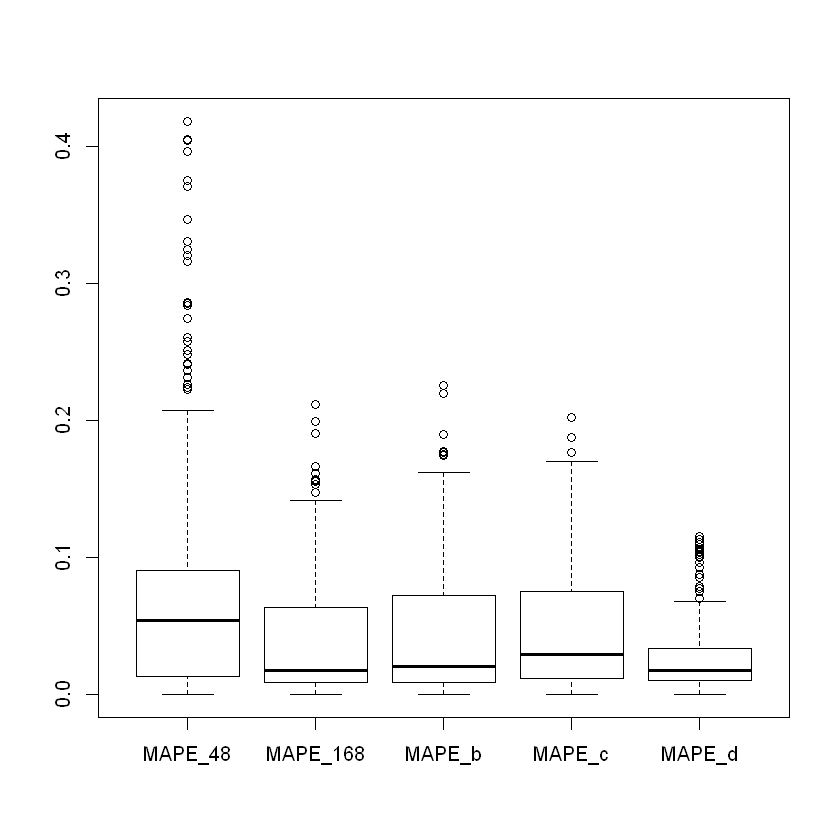

In [16]:
summary(overall)
boxplot(overall)